# Graph Neural Network approach

## Graph Convolutional Network
GCNs perform similar operations where the model learns the features by inspecting neighboring nodes. The major difference between CNNs and GNNs is that CNNs are specially built to operate on regular (Euclidean) structured data, while GNNs are the generalized version of CNNs where the numbers of nodes connections vary and the nodes are unordered (irregular on non-Euclidean structured data).

![](https://raw.githubusercontent.com/tkipf/pygcn/master/figure.png)

In [47]:
from typing import Any
import torch
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
import torch_geometric
!pip install rdkit-pypi
from rdkit import Chem, RDLogger
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import random
import networkx as nx
!pip install pysmiles
from pysmiles import read_smiles
import matplotlib.pyplot as plt

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
        'CHI_TETRAHEDRAL',
        'CHI_ALLENE',
        'CHI_SQUAREPLANAR',
        'CHI_TRIGONALBIPYRAMIDAL',
        'CHI_OCTAHEDRAL',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'UNSPECIFIED',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'QUADRUPLE',
        'QUINTUPLE',
        'HEXTUPLE',
        'ONEANDAHALF',
        'TWOANDAHALF',
        'THREEANDAHALF',
        'FOURANDAHALF',
        'FIVEANDAHALF',
        'AROMATIC',
        'IONIC',
        'HYDROGEN',
        'THREECENTER',
        'DATIVEONE',
        'DATIVE',
        'DATIVEL',
        'DATIVER',
        'OTHER',
        'ZERO',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOANY',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
    ],
    'is_conjugated': [False, True],
}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

def from_smiles(smiles: str, label, with_hydrogen: bool = False,
                kekulize: bool = False) -> 'torch_geometric.data.Data':
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        smiles (string, optional): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    RDLogger.DisableLog('rdApp.*')

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(
            atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))
        xs.append(x)

    x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices).t().view(2, -1)
    edge_attr = torch.tensor(edge_attrs).view(-1, 3)
    lab = torch.tensor(label)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles, y=lab)



def to_smiles(data: 'torch_geometric.data.Data',
              kekulize: bool = False) -> Any:
    """Converts a :class:`torch_geometric.data.Data` instance to a SMILES
    string.

    Args:
        data (torch_geometric.data.Data): The molecular graph.
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    mol = Chem.RWMol()

    for i in range(data.num_nodes):
        atom = Chem.Atom(data.x[i, 0].item())
        atom.SetChiralTag(Chem.rdchem.ChiralType.values[data.x[i, 1].item()])
        atom.SetFormalCharge(x_map['formal_charge'][data.x[i, 3].item()])
        atom.SetNumExplicitHs(x_map['num_hs'][data.x[i, 4].item()])
        atom.SetNumRadicalElectrons(
            x_map['num_radical_electrons'][data.x[i, 5].item()])
        atom.SetHybridization(
            Chem.rdchem.HybridizationType.values[data.x[i, 6].item()])
        atom.SetIsAromatic(data.x[i, 7].item())
        mol.AddAtom(atom)

    edges = [tuple(i) for i in data.edge_index.t().tolist()]
    visited = set()

    for i in range(len(edges)):
        src, dst = edges[i]
        if tuple(sorted(edges[i])) in visited:
            continue

        bond_type = Chem.BondType.values[data.edge_attr[i, 0].item()]
        mol.AddBond(src, dst, bond_type)

        # Set stereochemistry:
        stereo = Chem.rdchem.BondStereo.values[data.edge_attr[i, 1].item()]
        if stereo != Chem.rdchem.BondStereo.STEREONONE:
            db = mol.GetBondBetweenAtoms(src, dst)
            db.SetStereoAtoms(dst, src)
            db.SetStereo(stereo)

        # Set conjugation:
        is_conjugated = bool(data.edge_attr[i, 2].item())
        mol.GetBondBetweenAtoms(src, dst).SetIsConjugated(is_conjugated)

        visited.add(tuple(sorted(edges[i])))

    mol = mol.GetMol()

    if kekulize:
        Chem.Kekulize(mol)

    Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol)

    return Chem.MolToSmiles(mol, isomericSmiles=True)

Load dataset from csv

In [5]:
df = pd.read_csv('dataset.csv', header=0)
df.head()

,smile,flavor
0,C1C(C(C(OC1O)CO)O)O,sweet
1,C(CC(=O)O)C(=O)C(=O)O,odorless
2,CCC(=O)C(=O)O,sweet
3,C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)COP(=O)(O)O)O...,sweet
4,C1=CC=C(C=C1)CCC(=O)O,sweet


Map flavors to labels

In [7]:
mapper = {'sweet': 0, 'bitter': 1, 'odorless': 2}
for i in range(len(df)):
    df.iloc[i, 1] = mapper[df.iloc[i, 1]]

In [8]:
df.value_counts('flavor')

flavor
0    11710
1     1775
2      336
dtype: int64

Train/test split

In [9]:
sweet_df = df[df['flavor']==0]
bitter_df = df[df['flavor']==1]
odorless_df = df[df['flavor']==2]

test_sweet_df = sweet_df.sample(n=int(len(sweet_df)/10), random_state=101)
test_bitter_df = bitter_df.sample(n=int(len(bitter_df)/10), random_state=101)
test_odorless_df = odorless_df.sample(n=int(len(odorless_df)/10), random_state=101)
test_df = pd.concat([test_sweet_df, test_bitter_df])

sweet_df = pd.concat([sweet_df,test_sweet_df]).drop_duplicates(keep=False).sample(n=7000, random_state=101, replace=True)
bitter_df = pd.concat([bitter_df,test_bitter_df]).drop_duplicates(keep=False)#.sample(n=4000, random_state=101, replace=True)
odorless_df = pd.concat([odorless_df,test_odorless_df]).drop_duplicates(keep=False)#.sample(n=1000, random_state=101, replace=True)
train_df = pd.concat([sweet_df, bitter_df], axis=0)#, odorless_df],axis=0)

print(len(test_df))
print(len(train_df))

1348
8598


Get train part of smiles representation as graphs

In [10]:
train_smiles_lst = train_df.iloc[:, 0].tolist()
train_labels_lst = train_df.iloc[:, 1].tolist()

train_smiles_graph = []
for i in range(len(train_smiles_lst)):
    train_smiles_graph.append(from_smiles(train_smiles_lst[i], train_labels_lst[i]))

len(train_smiles_graph)

8598

Get test part of smiles representation as graphs

In [11]:
test_smiles_lst = test_df.iloc[:, 0].tolist()
test_labels_lst = test_df.iloc[:, 1].tolist()

test_smiles_graph = []
for i in range(len(test_smiles_lst)):
    test_smiles_graph.append(from_smiles(test_smiles_lst[i], test_labels_lst[i]))

len(test_smiles_graph)

1348

Visualise examplary smile graph

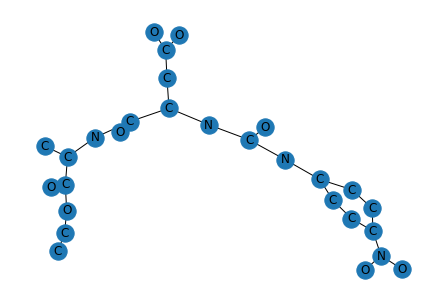

In [12]:
smiles = test_smiles_graph[0]['smiles']
mol = read_smiles(smiles)

elements = nx.get_node_attributes(mol, name = "element")
nx.draw(mol, with_labels=True, labels = elements, pos=nx.spring_layout(mol))
plt.gca().set_aspect('auto')

In [13]:
torch.manual_seed(12345)

train_dataset = train_smiles_graph
test_dataset = test_smiles_graph
random.shuffle(train_dataset)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 8598
Number of test graphs: 1348


Make dataloader and split into batches

In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    break

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1990, 9], edge_index=[2, 4222], edge_attr=[4222, 3], y=[64], smiles=[64], batch=[1990], ptr=[65])


Make GCN model

In [15]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(9, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2*hidden_channels)
        self.conv3 = GCNConv(2*hidden_channels, 4*hidden_channels)
        self.conv4 = GCNConv(4*hidden_channels, 8*hidden_channels)
        self.conv5 = GCNConv(8*hidden_channels, 16*hidden_channels)
        self.lin1 = Linear(16*hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 256)
  (conv4): GCNConv(256, 512)
  (conv5): GCNConv(512, 1024)
  (lin1): Linear(in_features=1024, out_features=2, bias=True)
)


Train and test model

In [39]:
from IPython.display import Javascript
import copy
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x.float().to(device), data.edge_index.type(torch.LongTensor).to(device), data.batch.to(device))  # Perform a single forward pass.
        loss = criterion(out, data.y.to(device))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float().to(device), data.edge_index.type(torch.LongTensor).to(device), data.batch.to(device)) 
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y.to(device)).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_acc_lst = []
test_acc_lst = []
best_test_acc = 0.0
for epoch in range(100):
    train()
    train_acc = test(train_loader)
    train_acc_lst.append(train_acc)
    test_acc = test(test_loader)
    if test_acc > best_test_acc:
        print("BEST MODEL UPDATE")
        best_test_acc = test_acc
        best_model_weights = copy.deepcopy(model.state_dict())
    test_acc_lst.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

BEST MODEL UPDATE
Epoch: 000, Train Acc: 0.8141, Test Acc: 0.8687
Epoch: 001, Train Acc: 0.8141, Test Acc: 0.8687
Epoch: 002, Train Acc: 0.8344, Test Acc: 0.8687
BEST MODEL UPDATE
Epoch: 003, Train Acc: 0.8503, Test Acc: 0.8754
Epoch: 004, Train Acc: 0.8339, Test Acc: 0.8316
Epoch: 005, Train Acc: 0.8622, Test Acc: 0.8731
Epoch: 006, Train Acc: 0.8218, Test Acc: 0.8687
Epoch: 007, Train Acc: 0.8638, Test Acc: 0.8754
Epoch: 008, Train Acc: 0.8505, Test Acc: 0.8546
BEST MODEL UPDATE
Epoch: 009, Train Acc: 0.8597, Test Acc: 0.8813
Epoch: 010, Train Acc: 0.8485, Test Acc: 0.8546
Epoch: 011, Train Acc: 0.8651, Test Acc: 0.8769
BEST MODEL UPDATE
Epoch: 012, Train Acc: 0.8614, Test Acc: 0.8858
Epoch: 013, Train Acc: 0.8617, Test Acc: 0.8769
Epoch: 014, Train Acc: 0.8466, Test Acc: 0.8776
Epoch: 015, Train Acc: 0.8590, Test Acc: 0.8709
Epoch: 016, Train Acc: 0.8445, Test Acc: 0.8806
Epoch: 017, Train Acc: 0.8141, Test Acc: 0.8687
Epoch: 018, Train Acc: 0.8446, Test Acc: 0.8731
Epoch: 019, Trai

Visualise accuracy

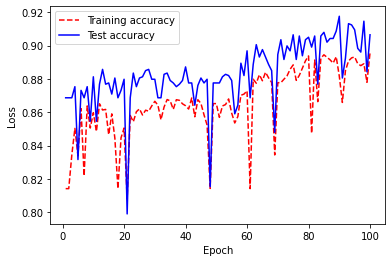

In [40]:
epoch_count = range(1, 100 + 1)
plt.plot(epoch_count, train_acc_lst, 'r--')
plt.plot(epoch_count, test_acc_lst, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [41]:
print(best_test_acc)

0.9176557863501483


Save best weighst:

In [42]:
torch.save(best_model_weights, "./best_model_weights.pt")

### Perform inference of best model:

Load best weights:

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel = GCN(hidden_channels=64)
mymodel = mymodel.to(device)
mymodel.load_state_dict(best_model_weights)

<All keys matched successfully>

Perform inference:

In [44]:
def test(loader):
     model.eval()
     correct = 0
     preds = []
     ys = []
     for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float().to(device), data.edge_index.type(torch.LongTensor).to(device), data.batch.to(device)) 
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y.to(device)).sum())  # Check against ground-truth labels.
        preds.append(pred.cpu().numpy())
        ys.append(data.y.cpu().numpy())
     return np.concatenate(preds), np.concatenate(ys)
preds, ys = test(test_loader)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(ys, preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1171
           1       0.62      0.74      0.68       177

    accuracy                           0.91      1348
   macro avg       0.79      0.84      0.81      1348
weighted avg       0.92      0.91      0.91      1348



In [46]:
sum(preds == 1)

211